# DIVI Intensivregister

## What are we dealing with?
It's a php-generated page containing a table which lists many (not all?) German clinics in a column labeled `Klinikname`. Other columns are labeled *Kontakt* = contact info, *Bundesland* = federal state, [*ICU*](https://en.wikipedia.org/wiki/Intensive_care_unit) *low care*, *ICU high care*, [*ECMO*](https://en.wikipedia.org/wiki/Extracorporeal_membrane_oxygenation) and *Stand* = time stamp. The columns *ICU* and *ECMO* solely contain colored bubbles to illustrate the availability of these resources. The legends explains as follows:

* red = *Verfügbar* = ready
* yellow = *Begrenzt* = limited
* green = *Ausgelastet* = exhausted
* unavailable = unknown state

A form offers sorting and filtering of that table.

## What to contribute?
The table only shows contemporary data as clinics submit their data (time stamp!). Aside to some statistics on that data -- what might be interesting to see is how it develops over time during the [COVID19](https://en.wikipedia.org/wiki/2019%E2%80%9320_coronavirus_pandemic) pandemic.

# Approach

## Fetch data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scrape import scrape, divi
plt.style.use('ggplot')

In [2]:
scrape_result = divi.to_dataframe(
    scrape.retry_getting(
        html="https://divi.de/register/intensivregister?view=items",
        params={
            "filter[search]": "",
            "list[fullordering]": "a.title+ASC",
            "list[limit]": 0,
            "filter[federalstate]": 0,
            "filter[chronosort]": 0,
            "filter[icu_highcare_state]": "",
            "filter[ecmo_state]": "",
            "filter[ards_network]": "",
            "limitstart": 0,
            "task": "",
            "boxchecked": 0,
            "07b860ef6bacf3cbfc30dc905ef94486": 1}),
    mapping=lambda x: x)
scrape_result

,Klinikname,Kontakt,Bundesland,ICU low care,ICU high care,ECMO,Stand
0,Gertrudis- Hospital Westerholt,Intensivstation Website,NRW,green,green,unavailable,2020-03-26 12:49:00
1,Evangelisches Krankenhaus Bergisch Gladbach,Intensivstation Website,NRW,red,green,unavailable,2020-03-26 12:29:00
2,OBERLIN KLINIK Potsdam,Wachstation - IMC Website,BB,green,green,unavailable,2020-03-26 12:27:00
3,LAKUMED Krankenhaus Vilsbiburg,D Website,BY,yellow,yellow,unavailable,2020-03-26 12:04:00
4,"Zentrum für Kinder- und Jugendmedizin, Päd. In...",Salge Website,BW,green,green,unavailable,2020-03-26 11:28:00
...,...,...,...,...,...,...,...
672,Universitätsklinikum Bonn,Operative Intensivmedizin Website,NRW,green,green,green,2020-03-25 13:17:00
673,Klinikum Nürnberg,Website,BY,green,green,green,2013-03-20 09:26:00
674,Helios Klinikum Bad Saarow,"ITS 1, ITS 2, ITS 3 Website",BB,yellow,green,green,2020-03-26 07:07:00
675,Elisabeth-Krankenhaus Essen,kardiologisch- internistische Intensivstation ...,NRW,green,green,green,2020-03-25 10:19:00


In [3]:
scrape_result.describe()

,Klinikname,Kontakt,Bundesland,ICU low care,ICU high care,ECMO,Stand
count,677,677,677,677,677,677,677
unique,665,297,16,3,3,4,570
top,Agaplesion Diakonieklinikum Rotenburg,Intensivstation Website,NRW,green,green,unavailable,2013-03-20 09:26:00
freq,2,120,156,497,525,478,8
first,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-20 09:26:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-26 12:50:00


Apparently, *St. Marienhospital Vechta gGmbH* has got a double entry.

## Raw data
Next, let's deduplicate and drop the contact info. Additionally, say the colors describe some kind of stress signal, turn colors into float values (red being high and green being low):

|  color        |  float  |
|:--------------|:-------:|
|  red          |   0.0   |
|  yellow       |   0.5   |
|  green        |   1.0   |
|  unavailable  |   NAN   |

In [4]:
df = scrape_result \
.drop_duplicates() \
.drop('Kontakt', axis=1) \
.replace({'green': 0.0, 'yellow': 0.5, 'red': 1.0, 'unavailable': np.nan})
df

,Klinikname,Bundesland,ICU low care,ICU high care,ECMO,Stand
0,Gertrudis- Hospital Westerholt,NRW,0.0,0.0,NaN,2020-03-26 12:49:00
1,Evangelisches Krankenhaus Bergisch Gladbach,NRW,1.0,0.0,NaN,2020-03-26 12:29:00
2,OBERLIN KLINIK Potsdam,BB,0.0,0.0,NaN,2020-03-26 12:27:00
3,LAKUMED Krankenhaus Vilsbiburg,BY,0.5,0.5,NaN,2020-03-26 12:04:00
4,"Zentrum für Kinder- und Jugendmedizin, Päd. In...",BW,0.0,0.0,NaN,2020-03-26 11:28:00
...,...,...,...,...,...,...
672,Universitätsklinikum Bonn,NRW,0.0,0.0,0.0,2020-03-25 13:17:00
673,Klinikum Nürnberg,BY,0.0,0.0,0.0,2013-03-20 09:26:00
674,Helios Klinikum Bad Saarow,BB,0.5,0.0,0.0,2020-03-26 07:07:00
675,Elisabeth-Krankenhaus Essen,NRW,0.0,0.0,0.0,2020-03-25 10:19:00


In [5]:
df.describe()

,ICU low care,ICU high care,ECMO
count,677.000000,677.000000,199.000000
mean,0.189069,0.144756,0.283920
std,0.339245,0.289904,0.412608
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.500000,0.000000,0.500000
max,1.000000,1.000000,1.000000


## Cleanup
How does the data contribution spread over time?

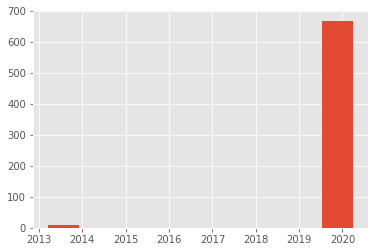

In [6]:
df.describe()
df['Stand'].hist()

Clean this up a bit: remove pre 19/20 contributions.

(array([737501., 737503., 737505., 737507., 737509., 737511.]),
 <a list of 6 Text major ticklabel objects>)

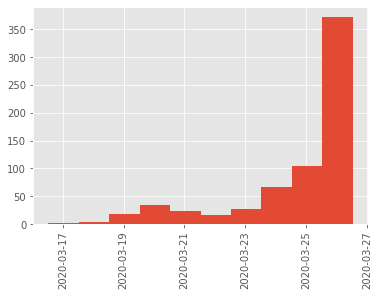

In [7]:
from datetime import datetime
df = df[(df['Stand'] > '2019-12-31') & (df['Stand'] <= datetime.now())]
df['Stand'].hist()
plt.xticks(rotation=90)

Better! Most contributions have been made recently, that's good.

## Plot using mean of values

Text(0, 0.5, 'federal state')

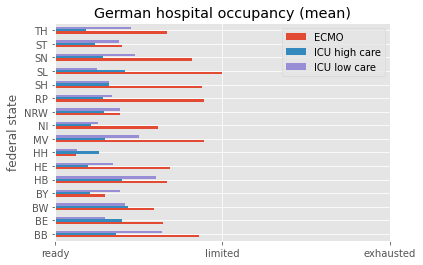

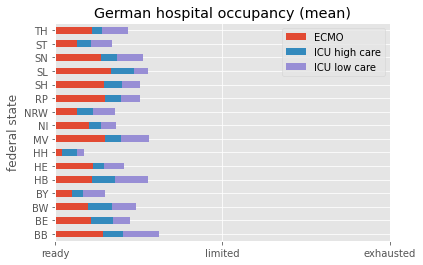

In [8]:
df \
.replace({'red': 1.0, 'yellow': 0.5, 'green': 0.0, 'unavailable': np.nan}) \
.groupby('Bundesland').mean().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO', 'ICU high care', 'ICU low care'], stacked=False)
plt.title("German hospital occupancy (mean)")
plt.xticks([0.0, 0.5, 1.0],["ready", "limited", "exhausted"])
plt.ylabel("federal state")
df \
.replace({'red': 1.0, 'yellow': 0.5, 'green': 0.0, 'unavailable': np.nan}) \
.groupby('Bundesland').mean().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO', 'ICU high care', 'ICU low care'], stacked=True)
plt.title("German hospital occupancy (mean)")
plt.xticks([0.0, 1.5, 3.0],["ready", "limited", "exhausted"]) # 3x[0..1] = [0..3]
plt.ylabel("federal state")

So much for contemporary data.

# Historic data
Instead of downloading the data from DIVI we are going to use the old scrapes in `data/divi.tsv`:

In [9]:
#!git pull 2&>1 >/dev/null
df = pd \
.read_csv("data/divi.tsv", sep="\t", index_col=0, parse_dates=True) \
.drop_duplicates() \
.drop('Kontakt', axis=1)
df

,Klinikname,Bundesland,ICU low care,ICU high care,ECMO,Stand
0,Heilig-Geist-Hospital Bingen gGmbH,RP,1.0,1.0,NaN,2020-03-25 23:56:00
1,Diakonissenkrankenhaus Flensburg,SH,1.0,0.5,NaN,2020-03-25 17:15:00
2,Evangelisches Krankenhaus Oberhausen - Kinderi...,NRW,1.0,1.0,NaN,2020-03-25 17:00:00
3,Bethlehem-Gesundheitszentrum,NRW,0.5,0.0,NaN,2020-03-25 16:57:00
4,Mediclin Herzzentrum Lahr/Baden,BW,1.0,1.0,1.0,2020-03-25 17:10:00
...,...,...,...,...,...,...
2362,Universitätsklinikum Dresden,SN,1.0,1.0,1.0,2020-03-24 14:25:00
2363,Universitätsklinikum Erlangen,BY,1.0,1.0,1.0,2020-03-24 08:27:00
2364,Universitätsklinikum Bonn,NRW,1.0,1.0,1.0,2020-03-22 15:55:00
2365,Helios Klinikum Bad Saarow,BB,0.5,1.0,1.0,2020-03-24 07:15:00


In [40]:
df.groupby('Klinikname').var().nlargest(10, ['ICU high care', 'ECMO'])

,ICU low care,ICU high care,ECMO
Klinikname,,,
Klinikum Ibbenbüren,0.0000,0.500000,0.00
St. Josefs-Hospital Wiesbaden,0.0000,0.500000,0.00
DRK Krankenhaus Ratzeburg,0.5000,0.500000,NaN
GFO Kliniken Niederrhein - St. Vinzenz-Hospital Dinslaken,0.0000,0.500000,NaN
Ketteler Krankenhaus Offenbach,0.0000,0.500000,NaN
Krankenhaus Düren gGmbH,0.5000,0.500000,NaN
Sana Krankenhaus Radevormwald,0.0000,0.500000,NaN
Sana Krankenhaus Templin,0.0000,0.500000,NaN
Evangelische Lungenklinik Berlin,0.0625,0.333333,NaN


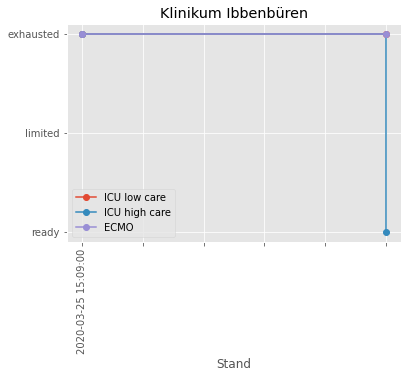

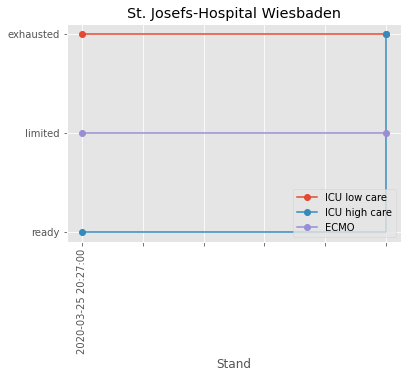

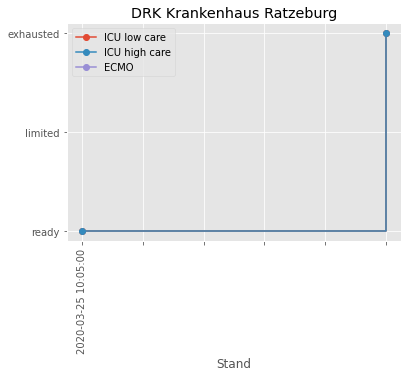

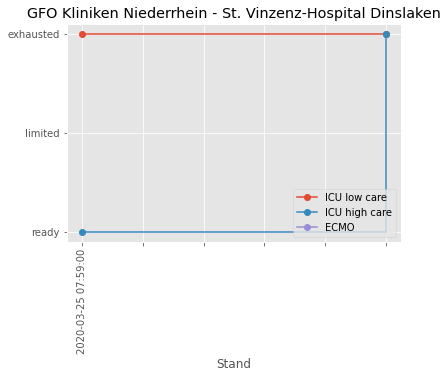

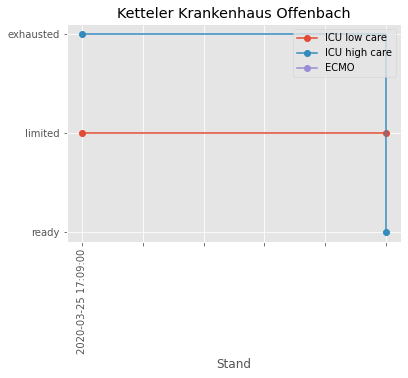

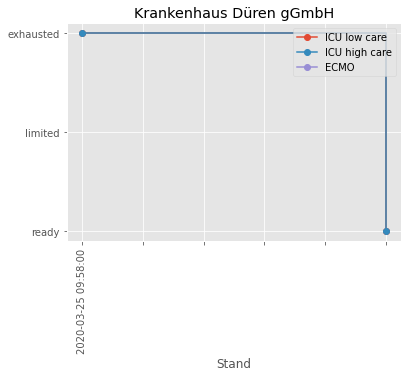

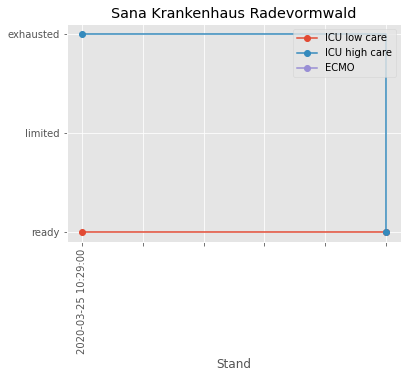

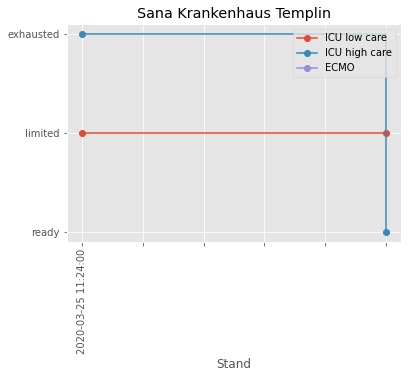

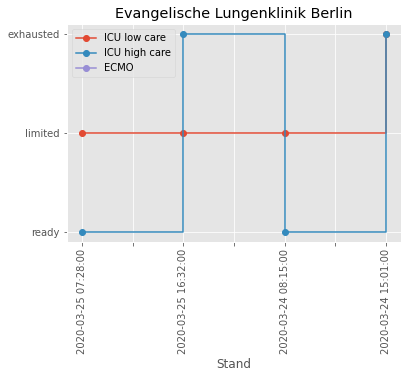

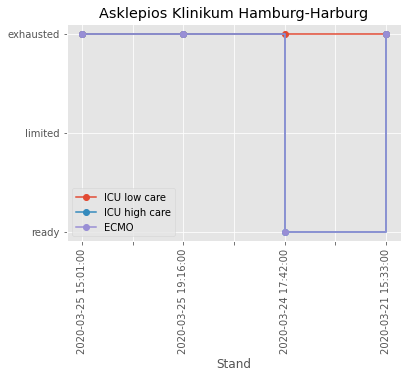

In [52]:
import matplotlib.dates as mdates
for clinic in df.groupby('Klinikname').var().nlargest(10, ['ICU high care', 'ECMO']).reset_index()['Klinikname']:
    df[df['Klinikname'] == clinic] \
    .set_index('Stand') \
    .plot(kind='line', 
          drawstyle="steps-post",
          y=['ICU low care', 'ICU high care', 'ECMO'],
          marker='o',
          rot=90)
    plt.yticks([0.0, 0.5, 1.0],["ready", "limited", "exhausted"])
    #.plot(kind='barh', x='Stand', y=['ICU low care', 'ICU high care', 'ECMO'])
    #plt.xticks([0.0, 0.5, 1.0],["ready", "limited", "exhausted"])
    plt.title(clinic)